In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.cluster import KMeans
from datetime import datetime

In [2]:
housing_data = pd.read_csv("Clean_Data/mls_th_cleaned.csv")
housing_data.head()

,MLS #,City,Zip,Bedrooms,Total Baths,SqFt,Acres,Year Built,List Date,Closing Date,List Price,Sold Price,Days on Market,Over Asking,Lat,Lon,Cluster,Price per SqFt
0,2509707,Cary,27511,4,4,6115,1,1985,2023-05-08,2023-06-12,1049900,1275000,35,225100,35.7641,-78.7786,2,208.503679
1,2444544,Chapel Hill,27517,4,5,4049,1,2004,2022-04-25,2022-06-07,1090000,1300000,43,210000,35.9182,-79.0035,1,321.066930
2,2320632,Durham,27707,3,5,2763,1,2020,2020-05-22,2021-08-05,575000,729840,440,154840,35.9631,-78.9315,1,264.147666
3,2428221,Cary,27511,3,4,3477,1,2004,2022-01-24,2022-02-09,949900,1100000,16,150100,35.7641,-78.7786,2,316.364682
4,10018970,Chapel Hill,27517,4,5,4049,1,2004,2024-04-06,2024-04-17,1350000,1500000,11,150000,35.9182,-79.0035,1,370.461842


In [3]:
# Convert date columns to datetime
housing_data['List Date'] = pd.to_datetime(housing_data['List Date'])
housing_data['Closing Date'] = pd.to_datetime(housing_data['Closing Date'])

In [4]:
# Extracting year and month from List Date and Closing Date
housing_data['List Year'] = housing_data['List Date'].dt.year
housing_data['List Month'] = housing_data['List Date'].dt.month
housing_data['Closing Year'] = housing_data['Closing Date'].dt.year
housing_data['Closing Month'] = housing_data['Closing Date'].dt.month

housing_data.head()

,MLS #,City,Zip,Bedrooms,Total Baths,SqFt,Acres,Year Built,List Date,Closing Date,...,Days on Market,Over Asking,Lat,Lon,Cluster,Price per SqFt,List Year,List Month,Closing Year,Closing Month
0,2509707,Cary,27511,4,4,6115,1,1985,2023-05-08,2023-06-12,...,35,225100,35.7641,-78.7786,2,208.503679,2023,5,2023,6
1,2444544,Chapel Hill,27517,4,5,4049,1,2004,2022-04-25,2022-06-07,...,43,210000,35.9182,-79.0035,1,321.066930,2022,4,2022,6
2,2320632,Durham,27707,3,5,2763,1,2020,2020-05-22,2021-08-05,...,440,154840,35.9631,-78.9315,1,264.147666,2020,5,2021,8
3,2428221,Cary,27511,3,4,3477,1,2004,2022-01-24,2022-02-09,...,16,150100,35.7641,-78.7786,2,316.364682,2022,1,2022,2
4,10018970,Chapel Hill,27517,4,5,4049,1,2004,2024-04-06,2024-04-17,...,11,150000,35.9182,-79.0035,1,370.461842,2024,4,2024,4


In [5]:
# Handling outliers
def handle_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df[column] = np.where(df[column] < lower_bound, lower_bound, df[column])
    df[column] = np.where(df[column] > upper_bound, upper_bound, df[column])

for col in ['List Price', 'Sold Price', 'SqFt', 'Days on Market', 'Price per SqFt']:
    handle_outliers(housing_data, col)

housing_data.head()

,MLS #,City,Zip,Bedrooms,Total Baths,SqFt,Acres,Year Built,List Date,Closing Date,...,Days on Market,Over Asking,Lat,Lon,Cluster,Price per SqFt,List Year,List Month,Closing Year,Closing Month
0,2509707,Cary,27511,4,4,3002.5,1,1985,2023-05-08,2023-06-12,...,35.00,225100,35.7641,-78.7786,2,208.503679,2023,5,2023,6
1,2444544,Chapel Hill,27517,4,5,3002.5,1,2004,2022-04-25,2022-06-07,...,43.00,210000,35.9182,-79.0035,1,298.678407,2022,4,2022,6
2,2320632,Durham,27707,3,5,2763.0,1,2020,2020-05-22,2021-08-05,...,258.25,154840,35.9631,-78.9315,1,264.147666,2020,5,2021,8
3,2428221,Cary,27511,3,4,3002.5,1,2004,2022-01-24,2022-02-09,...,16.00,150100,35.7641,-78.7786,2,298.678407,2022,1,2022,2
4,10018970,Chapel Hill,27517,4,5,3002.5,1,2004,2024-04-06,2024-04-17,...,11.00,150000,35.9182,-79.0035,1,298.678407,2024,4,2024,4


In [6]:
# Feature Engineering
housing_data['Price Increase Percentage'] = (housing_data['Sold Price'] - housing_data['List Price']) / housing_data['List Price']
housing_data['Age of Property'] = housing_data['Closing Year'] - housing_data['Year Built']

housing_data.head()

,MLS #,City,Zip,Bedrooms,Total Baths,SqFt,Acres,Year Built,List Date,Closing Date,...,Lat,Lon,Cluster,Price per SqFt,List Year,List Month,Closing Year,Closing Month,Price Increase Percentage,Age of Property
0,2509707,Cary,27511,4,4,3002.5,1,1985,2023-05-08,2023-06-12,...,35.7641,-78.7786,2,208.503679,2023,5,2023,6,0.008687,38
1,2444544,Chapel Hill,27517,4,5,3002.5,1,2004,2022-04-25,2022-06-07,...,35.9182,-79.0035,1,298.678407,2022,4,2022,6,0.008687,18
2,2320632,Durham,27707,3,5,2763.0,1,2020,2020-05-22,2021-08-05,...,35.9631,-78.9315,1,264.147666,2020,5,2021,8,0.068754,1
3,2428221,Cary,27511,3,4,3002.5,1,2004,2022-01-24,2022-02-09,...,35.7641,-78.7786,2,298.678407,2022,1,2022,2,0.008687,18
4,10018970,Chapel Hill,27517,4,5,3002.5,1,2004,2024-04-06,2024-04-17,...,35.9182,-79.0035,1,298.678407,2024,4,2024,4,0.008687,20


In [7]:
# Scaling numerical features
scaler = StandardScaler()
numerical_features = ['List Price', 'Sold Price', 'SqFt', 'Acres', 'Days on Market', 'Price per SqFt', 'Price Increase Percentage', 'Age of Property']
housing_data[numerical_features] = scaler.fit_transform(housing_data[numerical_features])

housing_data.head()

,MLS #,City,Zip,Bedrooms,Total Baths,SqFt,Acres,Year Built,List Date,Closing Date,...,Lat,Lon,Cluster,Price per SqFt,List Year,List Month,Closing Year,Closing Month,Price Increase Percentage,Age of Property
0,2509707,Cary,27511,4,4,2.740721,-0.087844,1985,2023-05-08,2023-06-12,...,35.7641,-78.7786,2,0.229471,2023,5,2023,6,-0.140416,1.941299
1,2444544,Chapel Hill,27517,4,5,2.740721,-0.087844,2004,2022-04-25,2022-06-07,...,35.9182,-79.0035,1,2.605393,2022,4,2022,6,-0.140416,0.457788
2,2320632,Durham,27707,3,5,2.198993,-0.087844,2020,2020-05-22,2021-08-05,...,35.9631,-78.9315,1,1.695578,2020,5,2021,8,1.034598,-0.803197
3,2428221,Cary,27511,3,4,2.740721,-0.087844,2004,2022-01-24,2022-02-09,...,35.7641,-78.7786,2,2.605393,2022,1,2022,2,-0.140416,0.457788
4,10018970,Chapel Hill,27517,4,5,2.740721,-0.087844,2004,2024-04-06,2024-04-17,...,35.9182,-79.0035,1,2.605393,2024,4,2024,4,-0.140416,0.606139


In [8]:
#Drop the MLS # Column
housing_data.drop('MLS #', axis=1, inplace=True)

#Drop the City Column
housing_data.drop('City', axis=1, inplace=True)

In [9]:
# Geospatial features (Optional - Based on necessity)
# Example: Clustering based on geographical location
kmeans = KMeans(n_clusters=5, random_state=42)
housing_data['Geo Cluster'] = kmeans.fit_predict(housing_data[['Lat', 'Lon']])

housing_data.head()

/opt/anaconda3/envs/dev/lib/python3.11/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


,Zip,Bedrooms,Total Baths,SqFt,Acres,Year Built,List Date,Closing Date,List Price,Sold Price,...,Lon,Cluster,Price per SqFt,List Year,List Month,Closing Year,Closing Month,Price Increase Percentage,Age of Property,Geo Cluster
0,27511,4,4,2.740721,-0.087844,1985,2023-05-08,2023-06-12,2.534087,2.557287,...,-78.7786,2,0.229471,2023,5,2023,6,-0.140416,1.941299,2
1,27517,4,5,2.740721,-0.087844,2004,2022-04-25,2022-06-07,2.534087,2.557287,...,-79.0035,1,2.605393,2022,4,2022,6,-0.140416,0.457788,3
2,27707,3,5,2.198993,-0.087844,2020,2020-05-22,2021-08-05,2.199023,2.557287,...,-78.9315,1,1.695578,2020,5,2021,8,1.034598,-0.803197,3
3,27511,3,4,2.740721,-0.087844,2004,2022-01-24,2022-02-09,2.534087,2.557287,...,-78.7786,2,2.605393,2022,1,2022,2,-0.140416,0.457788,2
4,27517,4,5,2.740721,-0.087844,2004,2024-04-06,2024-04-17,2.534087,2.557287,...,-79.0035,1,2.605393,2024,4,2024,4,-0.140416,0.606139,3


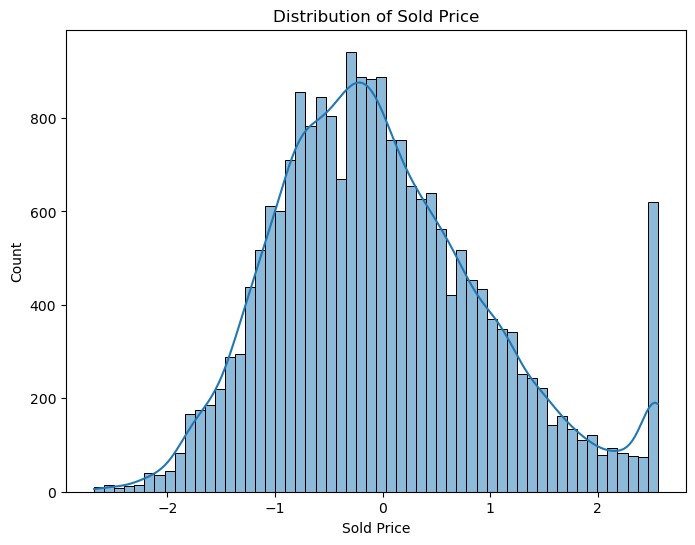

In [10]:
# Target variable analysis
plt.figure(figsize=(8, 6))
sns.histplot(housing_data['Sold Price'], kde=True)
plt.title('Distribution of Sold Price')
plt.show()

/opt/anaconda3/envs/dev/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


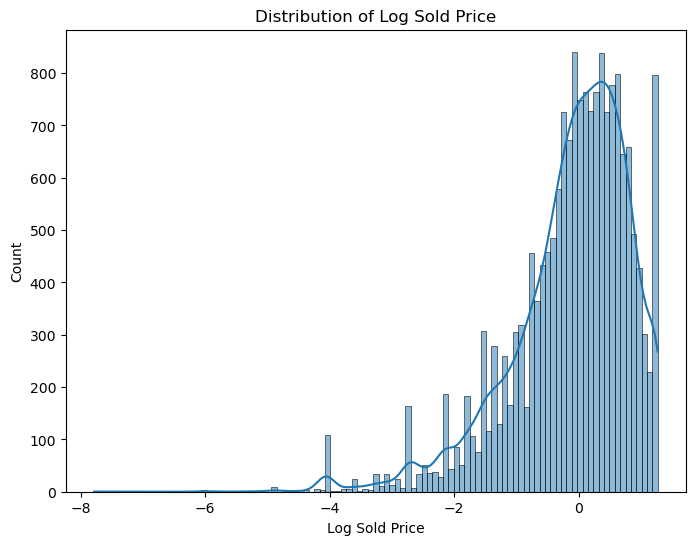

In [11]:
# Optional: Log transformation if skewed
housing_data['Log Sold Price'] = np.log1p(housing_data['Sold Price'])

plt.figure(figsize=(8, 6))
sns.histplot(housing_data['Log Sold Price'], kde=True)
plt.title('Distribution of Log Sold Price')
plt.show()

In [12]:
#Show all the values in the Sold Price column
housing_data['Sold Price']

0        2.557287
1        2.557287
2        2.557287
3        2.557287
4        2.557287
           ...   
21314   -0.096554
21315    2.557287
21316   -0.047422
21317    2.557287
21318    2.557287
Name: Sold Price, Length: 21319, dtype: float64

In [13]:


#Create a correlation matrix to see what the correlation is for Price per SqFt
corr_matrix = housing_data.corr()
corr_matrix["Sold Price"].sort_values(ascending=False)

Sold Price                   1.000000
List Price                   0.986934
Log Sold Price               0.854311
SqFt                         0.755999
Price per SqFt               0.521301
Total Baths                  0.475330
Bedrooms                     0.454927
Year Built                   0.366586
Closing Date                 0.241976
Closing Year                 0.217110
List Year                    0.196072
List Date                    0.192969
Days on Market               0.130212
Closing Month                0.062092
Over Asking                  0.034733
Lat                          0.026131
Geo Cluster                  0.011534
Acres                       -0.041221
Price Increase Percentage   -0.042353
Zip                         -0.049055
List Month                  -0.051092
Cluster                     -0.089573
Lon                         -0.109599
Age of Property             -0.351945
Name: Sold Price, dtype: float64

In [14]:
# Save the DataFrame to a CSV file
housing_data.to_csv('Clean_Data/mls_th_cleaned_3.csv', index=False)